In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib import colors

import xarray

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


In [2]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from ALLCools.plot.color import plot_colorbar
from ALLCools.plot.utilities import tight_hue_range


def sunbrust(pie_data, ax,
             hue=None, hue_portion=0.5,
             cmap='viridis', colorbar=True,
             colorbar_kws=None,
             inner_radius=0.25, outer_radius=1,
             anno_col=None, text_anno='text', anno_layer_size=0.05,
             col_color_dict=None, startangle=0, anno_ang_min=5,
             anno_border=1.2, text_expend=1.05,
             anno_colors=None, anno_layer_gap=0.02,
             uniform_section=False, order_dict=None):
    """
    Parameters
    ----------
    pie_data
        Tidy dataframe
    ax
    hue
    hue_portion
    cmap
    colorbar
    colorbar_kws
    inner_radius
    outer_radius
    anno_col
    text_anno
    anno_layer_size
    col_color_dict
    startangle
    anno_ang_min
    anno_border
    text_expend
    uniform_section
    order_dict

    Returns
    -------

    """
    return_axes = [ax]
    if order_dict is None:
        order_dict = {}

    # prepare hue colormap
    if hue is not None:
        if isinstance(hue, str):
            hue_data = pie_data.pop(hue)
        elif isinstance(hue, pd.Series):
            hue_data = hue
        else:
            hue_data = pd.Series(hue, index=pie_data.index)
        if not isinstance(cmap, colors.Colormap):
            cmap = plt.get_cmap(cmap)
        cmap.set_bad('gray')

        vmin, vmax = tight_hue_range(hue_data, hue_portion)
        norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
        col_color_dict = {}
        for col_name, col in pie_data.iteritems():
            reduce_col_data = hue_data.groupby(col).mean()
            col_color_dict[col_name] = {k: mapper.to_rgba(v)
                                        for k, v in reduce_col_data.iteritems()}

        # make colorbar
        if colorbar:
            _colorbar_kws = {'labelsize': 4,
                             'linewidth': 0.5,
                             'orientation': 'vertical'}
            if colorbar_kws is None:
                colorbar_kws = {}
            _colorbar_kws.update(colorbar_kws)
            bbox_to_anchor = _colorbar_kws.pop('bbox_to_anchor')

            cax = inset_axes(ax, width="3%", height="25%",
                             loc='lower right', borderpad=0,
                             bbox_to_anchor=bbox_to_anchor)
            cax = plot_colorbar(cax, cmap=cmap, cnorm=norm, hue_norm=(vmin, vmax),
                                label=hue_data.name, **_colorbar_kws)
            return_axes.append(cax)

    # prepare data
    if uniform_section:
        dedup_groups = pie_data.reset_index().set_index(pie_data.columns.tolist()).index.drop_duplicates()
        dedup_groups = pd.DataFrame(dedup_groups.tolist(), columns=pie_data.columns)
        pie_data = dedup_groups

    # prepare color
    _col_color_dict = {col: None for col in pie_data.columns}
    if col_color_dict is not None:
        _col_color_dict.update(col_color_dict)

    # prepare plot parameters
    ncols = pie_data.columns.size
    if anno_col is None:
        anno_layer_size = 0
        anno_layer_gap = 0
    outer_radius = outer_radius - anno_layer_size - anno_layer_gap
    layer_size = (outer_radius - inner_radius) / ncols

    # plot multiple donuts
    previous_order = pd.Series([])
    anno_wedges = []
    anno_names = []
    for col, col_name in enumerate(pie_data.columns):
        cur_radius = inner_radius + (col + 1) * layer_size
        col_pie_data = pie_data[col_name].value_counts()

        # manage order
        if col_name in order_dict:
            _ordered_data = col_pie_data.reindex(pd.Index(order_dict[col_name]))
            previous_order = _ordered_data
        else:
            if col == 0:
                _ordered_data = col_pie_data
                previous_order = _ordered_data
            else:
                records = []
                for section in previous_order.index:
                    section_subs = pie_data[pie_data.iloc[:, col - 1] == section][col_name].unique()
                    records.append(col_pie_data.reindex(pd.Index(section_subs)).sort_values(ascending=False))
                _ordered_data = pd.concat(records)
                previous_order = _ordered_data

        # plot the real pie charts
        pie_color = _col_color_dict[col_name]
        if isinstance(pie_color, dict):
            pie_color = [pie_color[i] for i in _ordered_data.index]
        ax.pie(_ordered_data, radius=cur_radius,
               colors=pie_color, startangle=startangle,
               wedgeprops=dict(width=layer_size, edgecolor='w'))

        # plot an additional thin layer to anchor anno label
        if anno_col == col:
            if anno_colors is not None:
                _color = [anno_colors[i] for i in order_dict[col_name]]
                
            else:
                _color = pie_color
            
            wedges, texts = ax.pie(_ordered_data, radius=outer_radius + anno_layer_gap + anno_layer_size,
                                   colors=_color, startangle=startangle,
                                   wedgeprops=dict(width=anno_layer_size, edgecolor='w'))
            if text_anno:
                anno_wedges = wedges
                anno_names = _ordered_data.index.tolist()

    # annotate wedges
    for i, p in enumerate(anno_wedges):
        delta_ang = p.theta2 - p.theta1
        if delta_ang < anno_ang_min:
            continue
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        if text_anno == 'anno_box':
            # wedges annotation
            bbox_props = dict(boxstyle="round,pad=0.2", fc="#FFFFFF88", ec="#00000022", lw=0.72)
            kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-", color='#00000055'),
                      bbox=bbox_props, zorder=0, va="center")
            # separate all y
            y_niche = np.arange(-anno_border, anno_border, anno_border / 10)
            allow_y_niche = OrderedDict(enumerate(y_niche))

            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang},rad=5"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})

            suitable_niche = np.abs(np.array(list(allow_y_niche.values())) - anno_border * y).argmin()
            suitable_niche = list(allow_y_niche.keys())[suitable_niche]
            y_niche = allow_y_niche.pop(suitable_niche)
            ax.annotate(anno_names[i], xy=(x, y), xytext=(anno_border * np.sign(x), y_niche),
                        horizontalalignment=horizontalalignment, **kw)
        elif text_anno == 'text':
            ha = 'left'
            if x < 0:
                # left side label
                ang += 180
                ha = 'right'
            if ang > 180:
                # so label will not be up-side-down
                ang = ang - 360
            ax.text(x * text_expend, y * text_expend, anno_names[i],
                    fontdict=None, withdash=False,
                    rotation=ang, va='center', ha=ha,
                    rotation_mode='anchor')
        elif text_anno is None:
            pass
        else:
            raise ValueError(f'text_anno can only be "text", "anno_box" or None, got {text_anno}')

    if len(return_axes) == 1:
        return ax
    else:
        return tuple(return_axes)


In [3]:
it_spatial_order = [
    'IT-L23+ORB', 'IT-L23+PFC', 'IT-L23+ACA', 'IT-L23+AI', 'IT-L23+MOs',
    'IT-L23+MOp', 'IT-L23+SSp', 'IT-L23+SSs', 'IT-L4+MOs', 'IT-L4+MOp',
    'IT-L4+SSp', 'IT-L4+SSs', 'IT-L5+ORB', 'IT-L5+PFC', 'IT-L5+ACA',
    'IT-L5+AI', 'IT-L5+MOs', 'IT-L5+MOp', 'IT-L5+SSp', 'IT-L5+SSs',
    'IT-L6+PFC', 'IT-L6+ACA', 'IT-L6+AI', 'IT-L6+MOs', 'IT-L6+MOp',
    'IT-L6+SSp', 'IT-L6+SSs'
]
layer_order = ['IT-L23', 'IT-L4', 'IT-L5', 'IT-L6']

cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['MajorType'].str.startswith('IT-')].copy()
cell_tidy_data['ITSpatial'] = cell_tidy_data['MajorType'] + '+' + cell_tidy_data['SubRegion']
counts = cell_tidy_data['ITSpatial'].value_counts() 
cell_tidy_data = cell_tidy_data[cell_tidy_data['ITSpatial'].isin(it_spatial_order)].copy()
cell_tidy_data.shape

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


(26877, 55)

In [4]:
region_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
sub_region_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
major_region_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
cell_class_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/order/CellClass.order.txt',
    index_col=0,
    header=None,
    sep='\t').index
major_type_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/order/MajorType-Copy1.order_by_l1_analysis_and_name.txt',
    index_col=0,
    header=None,
    sep='\t').index

cell_class_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
major_type_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()
sub_type_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'
        


In [5]:
spatial_group_palette = {c: sub_region_palette[c.split('+')[1]] for c in cell_tidy_data['ITSpatial'].unique()}

## Gene Data

In [6]:
gene_meta = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
                        sep='\t', index_col='gene_id')
gene_name_to_id = {v:k for k, v in gene_meta['gene_name'].iteritems()}

In [7]:
cluster_gene_level = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/DMGAnalysis/ITSpatialPairwiseDEG/ClusterMean.genes.msg'
)
cluster_gene_level.head()

gene,ENSMUSG00000102693.1,ENSMUSG00000064842.1,ENSMUSG00000051951.5,ENSMUSG00000102851.1,ENSMUSG00000103377.1,ENSMUSG00000104017.1,ENSMUSG00000103025.1,ENSMUSG00000089699.1,ENSMUSG00000103201.1,ENSMUSG00000103147.1,...,ENSMUSG00000064363.1,ENSMUSG00000064364.1,ENSMUSG00000064365.1,ENSMUSG00000064366.1,ENSMUSG00000064367.1,ENSMUSG00000064368.1,ENSMUSG00000064369.1,ENSMUSG00000064370.1,ENSMUSG00000064371.1,ENSMUSG00000064372.1
MajorSpatial,,,,,,,,,,,,,,,,,,,,,
IT-L23+ACA,1.084402,1.219037,0.600930,0.809410,0.807340,0.811416,0.770194,0.665284,0.885189,0.805581,...,1.215505,1.210745,1.208422,1.212762,1.262954,1.215362,1.174872,1.177260,1.163883,1.159027
IT-L23+AI,1.069829,1.190315,0.620239,0.805654,0.811764,0.843611,0.716939,0.683916,0.908095,0.773266,...,1.506355,1.516231,1.509593,1.509827,1.571510,1.442475,1.401113,1.435535,1.304210,1.308833
IT-L23+MOp,1.084030,1.264564,0.769442,0.857868,0.998639,0.950379,0.846915,0.795982,1.017603,0.817189,...,1.493491,1.487037,1.495002,1.498936,1.570738,1.529486,1.495524,1.514510,1.421230,1.407877
IT-L23+MOs,1.086669,1.267686,0.644932,0.800112,1.007805,0.885998,0.763844,0.699807,0.917063,0.782143,...,1.878517,1.858606,1.862492,1.867486,2.064359,1.970665,1.935784,1.968089,1.795532,1.789918
IT-L23+ORB,1.099660,1.181821,0.579719,0.791083,0.746848,0.812362,0.762827,0.642710,0.882473,0.781846,...,1.856874,1.840486,1.854101,1.883733,2.141459,2.063712,2.015252,2.046432,1.915413,1.912530


## Color By Brain Region and Layer

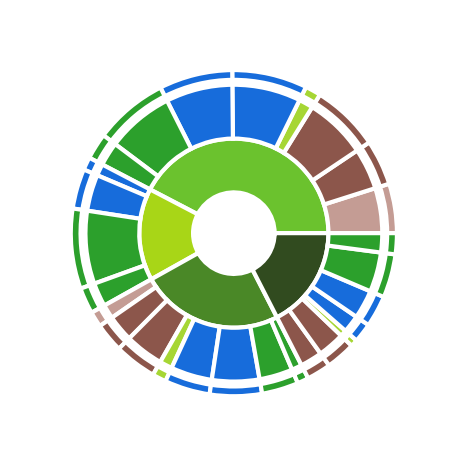

In [8]:
fig, ax = plt.subplots(figsize=(1.8, 1.8), dpi=300)
_cell_tidy_data = cell_tidy_data[['MajorType', 'ITSpatial']].copy()

sunbrust(pie_data=_cell_tidy_data,
         order_dict={
             'MajorType': layer_order,
             'ITSpatial': it_spatial_order
         },
         ax=ax,
         anno_col=1,
         text_anno=False,
         anno_layer_size=0.06,
         col_color_dict={
             'MajorType': major_type_palette,
             'ITSpatial': spatial_group_palette
         },
         startangle=0,
         anno_ang_min=0.001,
         anno_layer_gap=0.03,
         text_expend=1.05,
         uniform_section=False)

for t in ax.texts:
    t.set_fontsize(5)
fig.savefig('Sunburst.color_by_category.pdf')